In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [2]:


# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
len(chars)

26

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} # 1 for 'a', 2 for 'b', etc. 
stoi.update({'.': 0}) # 0 is reserved for '.'.
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(stoi)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words): 
    X, Y = [], []
    for w in words:
        context = [stoi['.']] * block_size # context is initialized to [0,0,0]
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # rightshift the context by 1, append the `ix` to its tail.
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

training_set_size = int(0.8 * len(words))
validating_set_size = int(0.1 * len(words))
testing_set_size = int(0.1 * len(words))

Xtr,  Ytr = build_dataset(words[:training_set_size])
Xdev, Ydev = build_dataset(words[training_set_size: training_set_size + validating_set_size])
Xte,  Yte = build_dataset(words[training_set_size + validating_set_size : training_set_size + validating_set_size + testing_set_size])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22859, 3]) torch.Size([22859])


In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Each input is a `n_embd * block_size`-D vector.
# There're `n_hidden` neurons in this layer
# After this layer, each input is converted to a `n_hidden`-D vector

# [kaiming initiazlization](https://pytorch.org/docs/stable/nn.init.html)
# Since the activation func is `tanh`, gain is set to 5/3
# Sicne the input (single) sample is a `n_embd * block_size`-30-D vector`, `fan_in`- 30
# So we will set the standard deviation to be gain / [(fan_in)^(0.5)] = 5/3 / 30**0.5 ~= 0.304
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # ~= * 0.3
b1 = torch.randn(n_hidden,                        generator=g) * 0.01

# After this layer, each input is converted to a `vocab_size`-D vector
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0


# BatchNorm parameters

# gamma
bngain = torch.ones((1, n_hidden))

# beta
bnbias = torch.zeros((1, n_hidden))

# We can use BP to update the gamma and beta, but since we are lazy, we can just use some simpler method--use some kind of moving average
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True



12097


In [8]:
C.shape, W1.shape, b1.shape

(torch.Size([27, 10]), torch.Size([30, 200]), torch.Size([200]))

In [10]:
# Xtr[[0, 1, 2]]
# Xtr[:3]
max_steps = 1
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  # torch.randint(low, high, size, *, generator=g): This is a PyTorch function that returns a tensor filled with random integers generated uniformly between low (inclusive) and high (exclusive). 
  # The size argument specifies the shape of the output tensor.
  # (batch_size,): This specifies the shape of the output tensor of random integers. 
  # The output will be a 1D tensor with a length equal to batch_size, which is a variable indicating how many indices (or items) you want to randomly select.
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  print(ix.shape)
  # Each `ix` is a 32-D vector, selecting 32 lines (or samples) from the training dataset
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  print(Xb.shape, Yb.shape)
  emb = C[Xb]
  print(emb.shape)
  embcat = emb.view(emb.shape[0], -1)
  print(embcat.shape)
  

torch.Size([32])
torch.Size([32, 3]) torch.Size([32])
torch.Size([32, 3, 10])
torch.Size([32, 30])


In [11]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  # torch.randint(low, high, size, *, generator=g): This is a PyTorch function that returns a tensor filled with random integers generated uniformly between low (inclusive) and high (exclusive). 
  # The size argument specifies the shape of the output tensor.
  # (batch_size,): This specifies the shape of the output tensor of random integers. 
  # The output will be a 1D tensor with a length equal to batch_size, which is a variable indicating how many indices (or items) you want to randomly select.
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  
  # Each `ix` is a 32-D vector, selecting 32 lines (or samples) from the training dataset
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  
  # embed the characters into vectors
  # For each character, it generates a 10-D embedding
  # For each sample (a length=3 context of characters), it generates a [3,10] embedding
  # For each batched sample (a 32 batch of length=3 contexts), it generates a [32, 3, 10] embedding
  emb = C[Xb] 
  
  # emb.shape[0]: This is the size of the first dimension of emb, which is the batch_size. By specifying this as the first dimension in the new shape, you're keeping the batch size unchanged.
  # -1: Passing -1 as a dimension to view() tells PyTorch to infer the size of this dimension based on the other dimensions and the total number of elements in the tensor. 
  # Essentially, it flattens the remaining dimensions of the tensor into a single dimension. This operation is akin to concatenating the vectors from the second and third dimensions of emb into a single dimension for each sample in the batch.
  # Now every sample (a length=3 context of characters) is flattened to a 3*10=32-D vector
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  
  # Therefore, the real (single, not batched) input of the MLP is the **flattened embedding** of the context.
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3013
  10000/ 200000: 2.0035
  20000/ 200000: 2.0043
  30000/ 200000: 2.0937
  40000/ 200000: 2.2616
  50000/ 200000: 2.1408
  60000/ 200000: 2.0564
  70000/ 200000: 2.3588
  80000/ 200000: 2.3619
  90000/ 200000: 2.2137
 100000/ 200000: 2.3094
 110000/ 200000: 1.8927
 120000/ 200000: 2.2329
 130000/ 200000: 2.0224
 140000/ 200000: 1.7848
 150000/ 200000: 2.3820
 160000/ 200000: 2.2525
 170000/ 200000: 1.7767
 180000/ 200000: 1.9479
 190000/ 200000: 2.2804


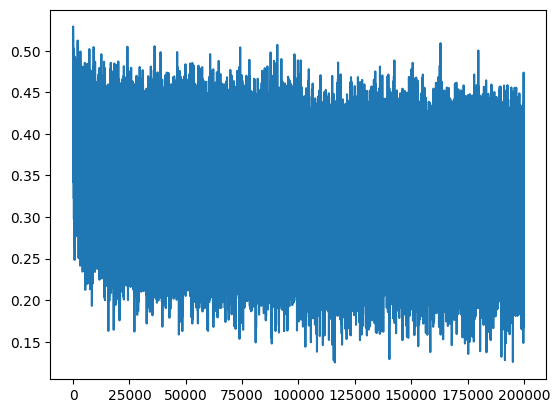

In [12]:
plt.plot(lossi)

In [13]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [14]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066471576690674
val 2.105135917663574


In [16]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [17]:


# same optimization as last time
max_steps = 2000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization



      0/   2000: 3.2870


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.28%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.59%
layer 8 (      Tanh): mean +0.00, std 0.65, saturated: 2.66%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.44%
layer 14 (      Tanh): mean -0.00, std 0.66, saturated: 1.34%


Text(0.5, 1.0, 'activation distribution')

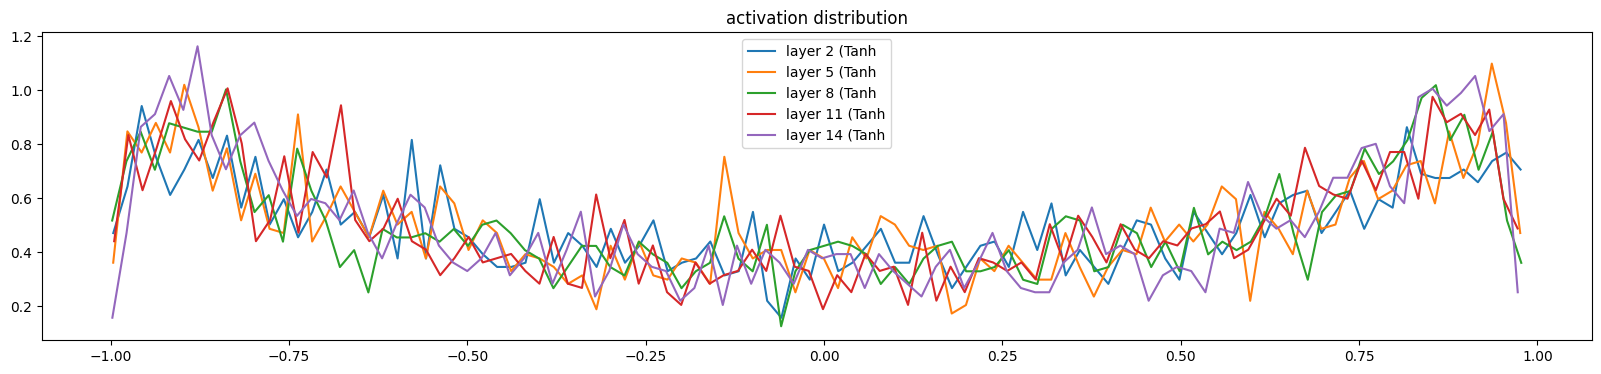

In [18]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [19]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False # Only allpy for BatchNorm1d layers
split_loss('train') 
split_loss('val')

train 2.321082353591919
val 2.3177363872528076


In [20]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word


chreah.
qalyn.
kif.
jmrixreety.
salana.
eja.
hutn.
del.
rhc.
kaqei.
nelynna.
chaiiv.
kaleig.
dhlm.
jora.
qhilthanlin.
alianni.
wate.
madiaryni.
jameenilsan.


In [ ]:
# visualize histograms of the grad of layers' outputs
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')